<h1>Demand forecasting with BigQuery and TensorFlow</h1>

In this notebook, we will develop a machine learning model to predict the demand for taxi cabs in New York.

To develop the model, we will need to get historical data of taxicab usage. This data exists in BigQuery. Let's start by looking at the schema.

In [25]:
import gcp.bigquery as bq
import pandas as pd
import numpy as np

In [26]:
%%bigquery schema --table "nyc-tlc:green.trips_2015"

<h2> Analyzing taxicab demand </h2>

Let's pull the number of trips for each day in the 2015 dataset.  We can use the BigQuery built-in Date-and-time function DAYOFYEAR (See <a href="https://cloud.google.com/bigquery/query-reference"> BigQuery query reference </a>) for a full list of such functions.

In [27]:
%%sql
SELECT DAYOFYEAR(pickup_datetime) AS daynumber FROM [nyc-tlc:green.trips_2015] LIMIT 10

daynumber
120
120
120
120
149
150
150
150
89
89


<h3> Modular queries and Pandas dataframe </h3>

Let's use the total number of trips as our proxy for taxicab demand (other reasonable alternatives are total trip_distance or total fare_amount).  It is possible to predict multiple variables using Tensorflow, but for simplicity, we will stick to just predicting the number of trips.

We will give our query a name 'taxiquery' and have it use an input variable '$YEAR'. We can then invoke the 'taxiquery' by giving it a YEAR.  The to_dataframe() converts the BigQuery result into a <a href='http://pandas.pydata.org/'>Pandas</a> dataframe.

In [28]:
%%sql --module taxiquery
SELECT daynumber, COUNT(*) AS numtrips FROM
    (SELECT DAYOFYEAR(pickup_datetime) AS daynumber FROM [nyc-tlc:green.trips_$YEAR])
GROUP BY daynumber ORDER BY daynumber

In [29]:
trips = bq.Query(taxiquery, YEAR=2015).to_dataframe()
trips[:5]

,daynumber,numtrips
0,1,62943
1,2,43410
2,3,53866
3,4,41602
4,5,41923


<h3> Benchmark </h3>

Often, a reasonable estimate of something is its historical average. We can therefore benchmark our machine learning model against the historical average.

In [30]:
avg = np.mean(trips['numtrips'])
print 'Just using average={0} has RMSE of {1}'.format(avg, np.sqrt(np.mean((trips['numtrips'] - avg)**2)))

Just using average=54674.0994475 has RMSE of 10163.4654442


The mean here is about 55,000 and the root-mean-square-error (RMSE) in this case is about 10,000. In other words, if we were to estimate that there are 55,000 taxi trips on any given day, that estimate is will be off on average by about 10,000 in either direction.
  
Let's see if we can do better than this -- our goal is to make predictions of taxicab demand whose RMSE is lower than 10,000.

What kinds of things affect people's use of taxicabs?

<h2> Weather data </h2>

We suspect that weather influences how often people use a taxi. Perhaps someone who'd normally walk to work would take a taxi if it is very cold or rainy.

Googler <a href="https://twitter.com/felipehoffa">Felipe Hoffa</a> has made weather observations from the US National Oceanic and Atmospheric Administration <a href-="http://stackoverflow.com/questions/34804654/how-to-get-the-historical-weather-for-any-city-with-bigquery/34804655">publicly</a> available in BigQuery. Let's use that dataset and find the station number corresponding to New York's La Guardia airport.


In [31]:
%%sql
SELECT * FROM [fh-bigquery:weather_gsod.stations]
WHERE state = 'NY' AND wban != '99999' AND name contains 'LA GUARDIA'

usaf,wban,name,country,fips,state,call,lat,lon,elev,begin,end
725030,14732,NEW YORK/LA GUARDIA,US,US,NY,KLGA,40779.0,-73880.0,94,19350222,20120619


<h3> Variables </h3>

Let's pull out the minimum and maximum daily temperature (in Fahrenheit) as well as the amount of rain (in inches) for La Guardia airport.

In [32]:
%%sql --module wxquery
SELECT DAYOFYEAR(TIMESTAMP('$YEAR'+mo+da)) daynumber,
       FIRST(DAYOFWEEK(TIMESTAMP('$YEAR'+mo+da))) dayofweek,
       MIN(min) mintemp, MAX(max) maxtemp, MAX(IF(prcp=99.99,0,prcp)) rain
FROM [fh-bigquery:weather_gsod.gsod$YEAR]
WHERE stn='725030' GROUP BY 1 ORDER BY daynumber DESC

In [33]:
weather = bq.Query(wxquery, YEAR=2015).to_dataframe()
weather[:5]

,daynumber,dayofweek,mintemp,maxtemp,rain
0,365,5,46.0,48.2,0.17
1,364,4,34.0,48.0,0.13
2,363,3,33.8,46.9,0.37
3,362,2,39.0,62.1,0.02
4,361,1,46.0,62.6,0.14


<h3> Merge datasets </h3>

Let's use Pandas to merge (combine) the taxi cab and weather datasets day-by-day.

In [34]:
data = pd.merge(weather, trips, on='daynumber')
data[:5]

,daynumber,dayofweek,mintemp,maxtemp,rain,numtrips
0,181,3,64.0,82.0,0.00,42978
1,180,2,62.1,78.1,0.26,41397
2,179,1,60.1,73.9,1.32,54632
3,178,7,62.1,80.1,0.00,74883
4,177,6,69.1,84.9,0.00,58371


<h3> Exploratory analysis </h3>

Is there a relationship between maximum temperature and the number of trips?

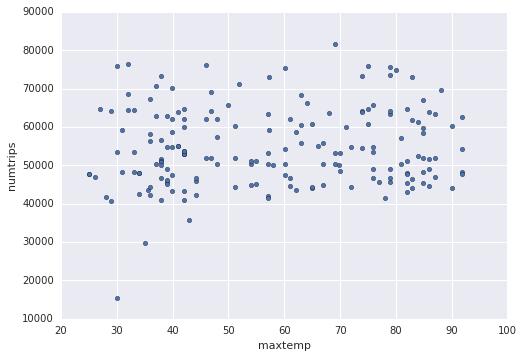

In [35]:
j = data.plot(kind='scatter', x='maxtemp', y='numtrips')

The scatterplot above doesn't look very promising. 

Is there a relationship between the day of the week and the number of trips?

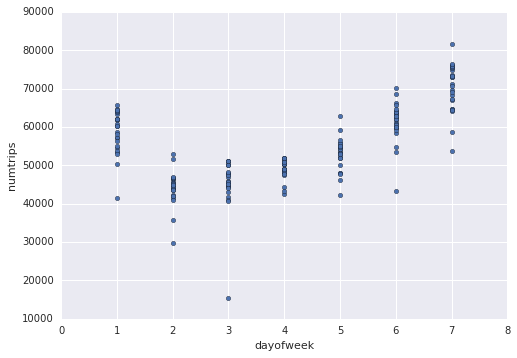

In [36]:
j = data.plot(kind='scatter', x='dayofweek', y='numtrips')

Hurrah, we seem to have found a predictor. It appears that people use taxis more later in the week. Perhaps New Yorkers make weekly resolutions to walk more and then lose their determination later in the week, or maybe it reflects tourism dynamics in New York City.

Perhaps if we took out the <em>confounding</em> effect of the day of the week, maximum temperature will start to have an effect. Let's see if that's the case:

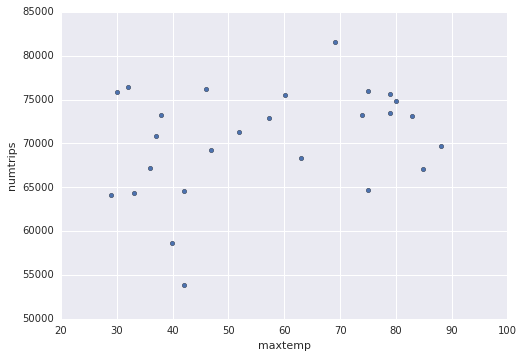

In [37]:
j = data[data['dayofweek'] == 7].plot(kind='scatter', x='maxtemp', y='numtrips')

Removing the confounding factor does seem to reflect an underlying trend around temperature. But ... the data are a little sparse, don't you think?  This is something that you have to keep in mind -- the more predictors you start to consider (here we are using two: day of week and maximum temperature), the more rows you will need so as to avoid <em> overfitting </em> the model.

<h3> Adding 2014 data </h3>

Let's add in 2014 data to the Pandas dataframe.  Note how useful it was for us to modularize our queries around the YEAR.

In [38]:
trips = bq.Query(taxiquery, YEAR=2014).to_dataframe()
weather = bq.Query(wxquery, YEAR=2014).to_dataframe()
data2014 = pd.merge(weather, trips, on='daynumber')
data2014[:5]

,daynumber,dayofweek,mintemp,maxtemp,rain,numtrips
0,365,4,27.0,35.1,0.0,67518
1,364,3,28.9,44.1,0.0,43173
2,363,2,37.9,52.0,0.1,37979
3,362,1,42.1,55.0,0.0,43055
4,361,7,39.9,55.0,0.0,46961


In [39]:
data2 = pd.concat([data, data2014])
data2.describe()

,daynumber,dayofweek,mintemp,maxtemp,rain,numtrips
count,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000
mean,152.501832,4.000000,43.511355,61.806410,0.130568,47130.009158
std,101.099356,2.001834,18.598263,19.169493,0.360620,11613.865885
min,1.000000,1.000000,3.000000,21.000000,0.000000,13436.000000
25%,69.000000,2.000000,28.225000,44.100000,0.000000,39150.250000
50%,137.000000,4.000000,44.100000,64.000000,0.000000,46720.500000
75%,228.750000,6.000000,61.000000,79.000000,0.070000,53855.500000
max,365.000000,7.000000,75.900000,93.000000,4.880000,81574.000000


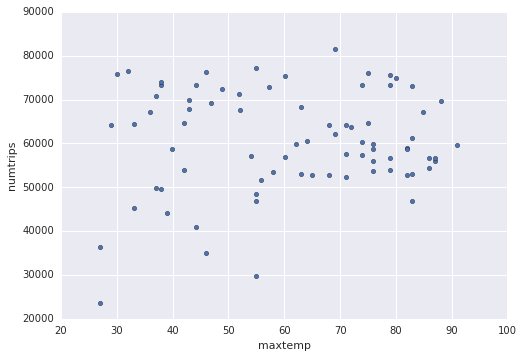

In [40]:
j = data2[data2['dayofweek'] == 7].plot(kind='scatter', x='maxtemp', y='numtrips')

The data do seem a bit more robust.  If we had more data, it would be better of course. But in this case, we only have 2014 and 2015 data, so that's what we will go with.

<h2> Machine Learning with Tensorflow </h2>

We'll use 80% of our dataset for training and 20% of the data for testing the model we have trained. Let's shuffle the rows of the Pandas dataframe so that this division is random.  The predictor (or input) columns will be every column in the database other than the number-of-trips (which is our target, or what we want to predict).

The machine learning models that we will use -- linear regression and neural networks -- both require that the input variables are numeric in nature.

The day of the week, however, is a categorical variable (i.e. Tuesday is not really greater than Monday). So, we should create separate columns for whether it is a Monday (with values 0 or 1), Tuesday, etc.

Against that, we do have limited data (remember: the more columns you use as input features, the more rows you need to have in your training dataset), and it appears that there is a clear linear trend by day of the week. So, we will opt for simplicity here and use the data as-is.  Try uncommenting the code that creates separate columns for the days of the week and re-run the notebook if you are curious about the impact of this simplification.

In [41]:
import tensorflow as tf
shuffled = data2.sample(frac=1)
# It would be a good idea, if we had more data, to treat the days as categorical variables
# with the small amount of data, we have though, the model tends to overfit
#predictors = shuffled.iloc[:,2:5]
#for day in xrange(1,8):
#  matching = shuffled['dayofweek'] == day
#  predictors.loc[matching, 'day_' + str(day)] = 1
#  predictors.loc[~matching, 'day_' + str(day)] = 0
predictors = shuffled.iloc[:,1:5]
predictors[:5]

,dayofweek,mintemp,maxtemp,rain
118,5,71.1,86.0,0.00
15,2,62.6,79.0,0.79
360,1,26.1,35.6,0.00
114,2,64.9,80.1,0.00
354,7,27.0,55.0,0.22


In [42]:
shuffled[:5]

,daynumber,dayofweek,mintemp,maxtemp,rain,numtrips
118,247,5,71.1,86.0,0.00,43408
15,166,2,62.6,79.0,0.79,46807
360,5,1,26.1,35.6,0.00,20560
114,251,2,64.9,80.1,0.00,37058
354,11,7,27.0,55.0,0.22,29799


In [43]:
targets = shuffled.iloc[:,5]
targets[:5]

118    43408
15     46807
360    20560
114    37058
354    29799
Name: numtrips, dtype: int64

Let's update our benchmark based on the 80-20 split and the larger dataset.

In [44]:
trainsize = int(len(shuffled['numtrips']) * 0.8)
avg = np.mean(shuffled['numtrips'][:trainsize])
rmse = np.sqrt(np.mean((shuffled['numtrips'][trainsize:] - avg)**2))
print 'Just using average={0} has RMSE of {1}'.format(avg, rmse)

Just using average=47147.5206422 has RMSE of 12732.1343487


<h2> Linear regression with Tensorflow </h2>

The key statements here are the model that we are creating:
<pre>
model = (tf.matmul(feature_data, weights) + biases) * SCALE_NUM_TRIPS
</pre>
which is a linear model and the error measure that we are minimizing:
<pre>
cost = tf.nn.l2_loss(model - target_data)
</pre>
which is the square-error (so what we are doing is least-squares linear regression).

The rest of this is pretty boiler plate.  The scaling is so that the optimization goes a lot better (when the weights are small numbers, things are more likely to converge, i.e., less likely to blow up).  We save the weights into /tmp/trained_model and display the root mean square error on the test dataset.

In [45]:
SCALE_NUM_TRIPS = 100000
trainsize = int(len(shuffled['numtrips']) * 0.8)
testsize = len(shuffled['numtrips']) - trainsize
npredictors = len(predictors.columns)
noutputs = 1
numiter = 10000
modelfile = '/tmp/trained_model'
with tf.Session() as sess:
  feature_data = tf.placeholder("float", [None, npredictors])
  target_data = tf.placeholder("float", [None, noutputs])
  weights = tf.Variable(tf.truncated_normal([npredictors, noutputs], stddev=0.01))
  biases = tf.Variable(tf.ones([noutputs]))
  model = (tf.matmul(feature_data, weights) + biases) * SCALE_NUM_TRIPS
  cost = tf.nn.l2_loss(model - target_data)
  training_step = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(cost)
  init = tf.initialize_all_variables()
  sess.run(init)

  saver = tf.train.Saver({'weights' : weights, 'biases' : biases})
  for iter in xrange(0, numiter):
    sess.run(training_step, feed_dict = {
        feature_data : predictors[:trainsize].values,
        target_data : targets[:trainsize].values.reshape(trainsize, noutputs)
      })
    
    if iter%1000 == 0:
      print '{0} error={1}'.format(iter, np.sqrt(cost.eval(feed_dict = {
          feature_data : predictors[:trainsize].values,
          target_data : targets[:trainsize].values.reshape(trainsize, noutputs)
      }) / trainsize))
    
  filename = saver.save(sess, modelfile, global_step=numiter)
  print 'Model written to {0}'.format(filename)

  print 'testerror={0}'.format(np.sqrt(cost.eval(feed_dict = {
          feature_data : predictors[trainsize:].values,
          target_data : targets[trainsize:].values.reshape(testsize, noutputs)
      }) / testsize))

0 error=37226.769573
1000 error=11397.6734661
2000 error=10759.6089285
3000 error=10037.6474454
4000 error=9306.57428869
5000 error=8646.24931995
6000 error=8103.11729799
7000 error=7699.99690218
8000 error=7440.12137614
9000 error=7305.52026543
Model written to /tmp/trained_model-10000
testerror=8386.6236006


The test error of about 8400 indicates that we are doing better with the machine learning model than we would be if we were to just use the historical average (our benchmark).

<h2> Neural network with Tensorflow </h2>

To change from linear regression to neural network regression, change the model to have more layers, and insert functional transformations of the linear combinations (here we do relu, but we could also do tanh or sigmoid):
<pre>
model = (tf.matmul(tf.nn.relu(tf.matmul(feature_data, weights1) + biases1), weights2) + biases2) * SCALE_NUM_TRIPS
</pre>

There are more weights, which need to be saved and retrieved, but the boilerplate code remains mostly the same as the linear regression example.

In [46]:
SCALE_NUM_TRIPS = 100000
trainsize = int(len(shuffled['numtrips']) * 0.8)
testsize = len(shuffled['numtrips']) - trainsize
npredictors = len(predictors.columns)
noutputs = 1
nhidden = 5
numiter = 10000
modelfile = '/tmp/trained_model'
with tf.Session() as sess:
  feature_data = tf.placeholder("float", [None, npredictors])
  target_data = tf.placeholder("float", [None, noutputs])
  weights1 = tf.Variable(tf.truncated_normal([npredictors, nhidden], stddev=0.01))
  weights2 = tf.Variable(tf.truncated_normal([nhidden, noutputs], stddev=0.01))
  biases1 = tf.Variable(tf.ones([nhidden]))
  biases2 = tf.Variable(tf.ones([noutputs]))
  model = (tf.matmul(tf.nn.relu(tf.matmul(feature_data, weights1) + biases1), weights2) + biases2) * SCALE_NUM_TRIPS
  cost = tf.nn.l2_loss(model - target_data)
  training_step = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(cost)
  init = tf.initialize_all_variables()
  sess.run(init)

  saver = tf.train.Saver({'weights1' : weights1, 'biases1' : biases1, 'weights2' : weights2, 'biases2' : biases2})
  for iter in xrange(0, numiter):
    sess.run(training_step, feed_dict = {
        feature_data : predictors[:trainsize].values,
        target_data : targets[:trainsize].values.reshape(trainsize, noutputs)
      })
    
    if iter%1000 == 0:
      print '{0} error={1}'.format(iter, np.sqrt(cost.eval(feed_dict = {
          feature_data : predictors[:trainsize].values,
          target_data : targets[:trainsize].values.reshape(trainsize, noutputs)
      }) / trainsize))
    
  filename = saver.save(sess, modelfile, global_step=numiter)
  print 'Model written to {0}'.format(filename)

  print 'testerror={0}'.format(np.sqrt(cost.eval(feed_dict = {
          feature_data : predictors[trainsize:].values,
          target_data : targets[trainsize:].values.reshape(testsize, noutputs)
      }) / testsize))

0 error=38225.6868073
1000 error=10581.3908453
2000 error=8598.12454908
3000 error=7775.54995489
4000 error=7289.19077071
5000 error=7166.95208592
6000 error=7115.87436393
7000 error=7073.102492
8000 error=7059.94672122
9000 error=7048.97842816
Model written to /tmp/trained_model-10000
testerror=8181.71200578


Using a neural network does seem to get us an additional boost in performance (8400 to 8200 when I ran it -- because of random seeds, your actual answers might be different).

<h2> Running a trained model </h2>

So, we have trained a model, and saved it to a file. Let's use this model to predict taxicab demand given the expected weather for three days.

Here we make a Dataframe out of those inputs, load up the saved model (note that we have to know the model equation -- it's not saved in the model file) and use it to predict the taxicab demand.

In [47]:
input = pd.DataFrame.from_dict(data = 
                               {'dayofweek' : [4, 5, 6],
                                'mintemp' : [50, 36, 54],
                                'maxtemp' : [80, 40, 75],
                                'rain' : [0, 0.8, 0.3]})
with tf.Session() as sess:
    filename = modelfile + '-' + str(numiter)
    saver = tf.train.Saver({'weights1' : weights1, 'biases1' : biases1, 'weights2' : weights2, 'biases2' : biases2})
    saver.restore(sess, filename)
    feature_data = tf.placeholder("float", [None, npredictors])
    predict_operation = (tf.matmul(tf.nn.relu(tf.matmul(feature_data, weights1) + biases1), weights2) + biases2) * SCALE_NUM_TRIPS
    predicted = sess.run(predict_operation, feed_dict = {
        feature_data : input.values
      })
    print predicted

[[ 32465.81054688]
 [ 49777.13671875]
 [ 41207.85546875]]


Looks like we should tell some of our taxi drivers to take the day off on Wednesday (day=4) and be there in full strength on Thursday (day=5).  No wonder -- the forecast calls for near-freezing rain on Thursday!

Note that Thursdays are usually "slow" days (taxi demand peaks on the weekends), but the machine learning model tells us to expect heavy demand this particular Thursday because of the weather.